In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna import Trial
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , ExtraTreesClassifier , VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV , cross_val_score , StratifiedKFold , learning_curve

c:\Users\abeta\anaconda3\envs\forcompe\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")
df_ = df.copy()

In [4]:

df_["credit_goods_price_ratio"] = df_["AMT_CREDIT"] / df_["AMT_GOODS_PRICE"]
df_["credit_downpayment"] = df_["AMT_GOODS_PRICE"] - df_["AMT_CREDIT"]
df_["AGE_INT"] = (df_["DAYS_BIRTH"] / -365).astype(int)

In [5]:

test["credit_goods_price_ratio"] = test["AMT_CREDIT"] / test["AMT_GOODS_PRICE"]
test["credit_downpayment"] = test["AMT_GOODS_PRICE"] - test["AMT_CREDIT"]
test["AGE_INT"] = (test["DAYS_BIRTH"] / -365).astype(int)

In [6]:
# 파생변수 생성
df_["AMT_Percentage"] = df_["AMT_ANNUITY"] +df_["AMT_GOODS_PRICE"]/ df_["AMT_CREDIT"]
test["AMT_Percentage"] = test["AMT_ANNUITY"] +test["AMT_GOODS_PRICE"]/ test["AMT_CREDIT"]



In [7]:
df_['INCOME_TOTAL_CREDIT'] = df_['AMT_INCOME_TOTAL'] / df_['AMT_CREDIT']
    
df_['DAYS_BIRTH_365_OWN_CAR_AGE'] = (df_['DAYS_BIRTH'] / 365) - df_['OWN_CAR_AGE']

df_['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [8]:

test['INCOME_TOTAL_CREDIT'] = test['AMT_INCOME_TOTAL'] / test['AMT_CREDIT']
    
test['DAYS_BIRTH_365_OWN_CAR_AGE'] = (test['DAYS_BIRTH'] / 365) - test['OWN_CAR_AGE']

test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [9]:
test['DAYS_BIRTH'] = test['DAYS_BIRTH']//-360
# # 年齢を5歳ごとにラベリング（20から71までの範囲）
bins = range(20, 76, 5)  # 20から75まで5刻みのビンを作成
labels = list(range(1, len(bins)))  # 各ビンに対する数値ラベルを作成
test['age_group'] = pd.cut(test['DAYS_BIRTH'], bins=bins, labels=labels, right=False)

test['EXT_23_mean'] = (test['EXT_SOURCE_2'] + test['EXT_SOURCE_3']) / 2
test['EXT_12_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_2']) / 2
test['EXT_13_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_3']) / 2
test['EXT_123_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_2'] + test['EXT_SOURCE_3']) / 3

# 勤続日数/年齢日数
test['DAYS_EMPLOYED_PERC'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
# # 総収入/借入額
test['INCOME_CREDIT_PERC'] = test['AMT_INCOME_TOTAL'] / test['AMT_CREDIT']
# # 総収入/家族人数
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
# # 月々の返済額/総収入
test['ANNUITY_INCOME_PERC'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
# # 月々の返済額/借入額
test['PAYMENT_RATE'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']

In [12]:
# 特徴量作成
df_['DAYS_BIRTH'] = df_['DAYS_BIRTH']//-360
# # 年齢を5歳ごとにラベリング（20から71までの範囲）
bins = range(20, 76, 5)  # 20から75まで5刻みのビンを作成
labels = list(range(1, len(bins)))  # 各ビンに対する数値ラベルを作成
df_['age_group'] = pd.cut(df_['DAYS_BIRTH'], bins=bins, labels=labels, right=False)

df_['EXT_23_mean'] = (df_['EXT_SOURCE_2'] + df_['EXT_SOURCE_3']) / 2
df_['EXT_12_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_2']) / 2
df_['EXT_13_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_3']) / 2
df_['EXT_123_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_2'] + df_['EXT_SOURCE_3']) / 3

# 勤続日数/年齢日数
df_['DAYS_EMPLOYED_PERC'] = df_['DAYS_EMPLOYED'] / df_['DAYS_BIRTH']
# # 総収入/借入額
df_['INCOME_CREDIT_PERC'] = df_['AMT_INCOME_TOTAL'] / df_['AMT_CREDIT']
# # 総収入/家族人数
df_['INCOME_PER_PERSON'] = df_['AMT_INCOME_TOTAL'] / df_['CNT_FAM_MEMBERS']
# # 月々の返済額/総収入
df_['ANNUITY_INCOME_PERC'] = df_['AMT_ANNUITY'] / df_['AMT_INCOME_TOTAL']
# # 月々の返済額/借入額
df_['PAYMENT_RATE'] = df_['AMT_ANNUITY'] / df_['AMT_CREDIT']




In [13]:
df_['AGE_YEARS'] = df_['DAYS_BIRTH'] / -365

df_['PAYMENT_Difference'] =  df_['AMT_CREDIT']  - df_['AMT_ANNUITY'] 
df_['CREDIT_INCOME_PERC'] =  df_['AMT_CREDIT']/df_['AMT_INCOME_TOTAL'] 
df_['YEARS_EMPLOYED'] = df_['DAYS_EMPLOYED'] / -365
education_income_mean = df_.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL'].mean()
df_['EDU_INCOME_ABOVE_AVG'] = df_.apply(
    lambda x: 1 if x['AMT_INCOME_TOTAL'] > education_income_mean[x['NAME_EDUCATION_TYPE']] else 0,
    axis=1
)

df_['AVG_REGION_RATING'] = (df_['REGION_RATING_CLIENT'] + df_['REGION_RATING_CLIENT_W_CITY']) / 2
df_['SOCIAL_CIRCLE_RATIO'] = df_['OBS_30_CNT_SOCIAL_CIRCLE'] / df_['DEF_30_CNT_SOCIAL_CIRCLE']
income_std_by_type = df_.groupby('NAME_INCOME_TYPE')['AMT_INCOME_TOTAL'].std()
df_['INCOME_STD'] = df_['NAME_INCOME_TYPE'].map(income_std_by_type)
df_['REALTY_AGE_RATIO'] = df_['OWN_CAR_AGE'] / df_['AGE_YEARS']


In [14]:
test['AGE_YEARS'] = test['DAYS_BIRTH'] / -365
test['PAYMENT_Difference'] =  test['AMT_CREDIT'] - test['AMT_ANNUITY'] 
test['CREDIT_INCOME_PERC'] =  test['AMT_CREDIT']/test['AMT_INCOME_TOTAL'] 
test['YEARS_EMPLOYED'] = test['DAYS_EMPLOYED'] / -365
education_income_mean = test.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL'].mean()
test['EDU_INCOME_ABOVE_AVG'] = test.apply(
    lambda x: 1 if x['AMT_INCOME_TOTAL'] > education_income_mean[x['NAME_EDUCATION_TYPE']] else 0,
    axis=1
)

test['AVG_REGION_RATING'] = (test['REGION_RATING_CLIENT'] + test['REGION_RATING_CLIENT_W_CITY']) / 2
test['SOCIAL_CIRCLE_RATIO'] = test['OBS_30_CNT_SOCIAL_CIRCLE'] / test['DEF_30_CNT_SOCIAL_CIRCLE']
income_std_by_type = test.groupby('NAME_INCOME_TYPE')['AMT_INCOME_TOTAL'].std()
test['INCOME_STD'] = test['NAME_INCOME_TYPE'].map(income_std_by_type)
test['REALTY_AGE_RATIO'] = test['OWN_CAR_AGE'] / test['AGE_YEARS']


In [15]:
occupation_income_mean = df_.groupby('OCCUPATION_TYPE')['AMT_INCOME_TOTAL'].mean()
df_['INCOME_OCCUPATION_DIFF'] = df_['AMT_INCOME_TOTAL'] - df_['OCCUPATION_TYPE'].map(occupation_income_mean)


In [16]:
occupation_income_mean = test.groupby('OCCUPATION_TYPE')['AMT_INCOME_TOTAL'].mean()
test['INCOME_OCCUPATION_DIFF'] = test['AMT_INCOME_TOTAL'] - test['OCCUPATION_TYPE'].map(occupation_income_mean)


In [17]:
df_['MOBILE_OCCUPATION'] = df_['FLAG_CONT_MOBILE'].astype(str) + '_' + df_['OCCUPATION_TYPE']
df_['HOUSING_INCOME'] = df_['NAME_HOUSING_TYPE'] + '_' + df_['AMT_INCOME_TOTAL'].astype(str)


In [18]:
test['MOBILE_OCCUPATION'] = test['FLAG_CONT_MOBILE'].astype(str) + '_' + test['OCCUPATION_TYPE']
test['HOUSING_INCOME'] = test['NAME_HOUSING_TYPE'] + '_' + test['AMT_INCOME_TOTAL'].astype(str)


In [19]:
dropcolumns = ["age_group",'FLAG_MOBIL','REG_REGION_NOT_LIVE_REGION','FLAG_CONT_MOBILE','FLAG_EMAIL','FLAG_EMP_PHONE','LIVE_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION','REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY','AMT_REQ_CREDIT_BUREAU_HOUR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','CNT_CHILDREN','FLAG_PHONE']
df_.drop(dropcolumns,axis = 1,inplace=True)
test.drop(dropcolumns,axis = 1,inplace=True)

df_["NAME_INCOME_TYPE"] = df_["NAME_INCOME_TYPE"].replace(['Pensioner','Commercial associate','Student',
                                                            'Businessman','Maternity leave','Unemployed'],np.nan)
df_["NAME_EDUCATION_TYPE"] = df_["NAME_EDUCATION_TYPE"].replace(['Lower secondary','Incomplete higher'] ,np.nan)
df_["NAME_HOUSING_TYPE"] = df_["NAME_HOUSING_TYPE"].replace( ['Co-op apartment','Municipal apartment'],np.nan)

test["NAME_INCOME_TYPE"] = test["NAME_INCOME_TYPE"].replace(['Pensioner','Commercial associate','Student',
                                                            'Businessman','Maternity leave','Unemployed'],np.nan)
test["NAME_EDUCATION_TYPE"] = test["NAME_EDUCATION_TYPE"].replace(['Lower secondary','Incomplete higher'] ,np.nan)
test["NAME_HOUSING_TYPE"] = test["NAME_HOUSING_TYPE"].replace( ['Co-op apartment','Municipal apartment'],np.nan)

# model

In [20]:
Ndf = df_.copy()
Ntest = test.copy()


In [21]:
Ndf = Ndf.replace([np.inf,-np.inf],np.nan)
Ntest =  Ntest.replace([np.inf,-np.inf],np.nan)

In [15]:
Ndf[Ndf["TARGET"]== 1].count()

SK_ID_CURR                     13821
TARGET                         13821
NAME_CONTRACT_TYPE             13821
CODE_GENDER                    13821
FLAG_OWN_CAR                   11139
AMT_INCOME_TOTAL               13821
AMT_CREDIT                     13821
AMT_ANNUITY                    13821
AMT_GOODS_PRICE                13808
NAME_INCOME_TYPE               13821
NAME_EDUCATION_TYPE            13821
NAME_FAMILY_STATUS             13821
NAME_HOUSING_TYPE              13821
REGION_POPULATION_RELATIVE     13821
DAYS_BIRTH                     13821
DAYS_EMPLOYED                  12145
DAYS_REGISTRATION              13821
DAYS_ID_PUBLISH                13821
OWN_CAR_AGE                     4221
FLAG_WORK_PHONE                13821
OCCUPATION_TYPE                10299
CNT_FAM_MEMBERS                13821
REGION_RATING_CLIENT           13821
REGION_RATING_CLIENT_W_CITY    13821
REG_CITY_NOT_LIVE_CITY         13821
ORGANIZATION_TYPE              13821
EXT_SOURCE_1                    3914
E

In [19]:
I =list(Ntest.select_dtypes("int").columns)
F = list(Ntest.select_dtypes("float").columns)
numcolumns = I+F


In [20]:

removecolumns = ["SK_ID_CURR","REGION_POPULATION_RELATIVE",'FLAG_WORK_PHONE',
                 'REGION_RATING_CLIENT_W_CITY','REG_CITY_NOT_LIVE_CITY','CNT_FAM_MEMBERS']
for i in removecolumns:
    numcolumns.remove(i)
print(len(numcolumns))

36


int or float columns : 36


KeyError: 'AGE_INT'

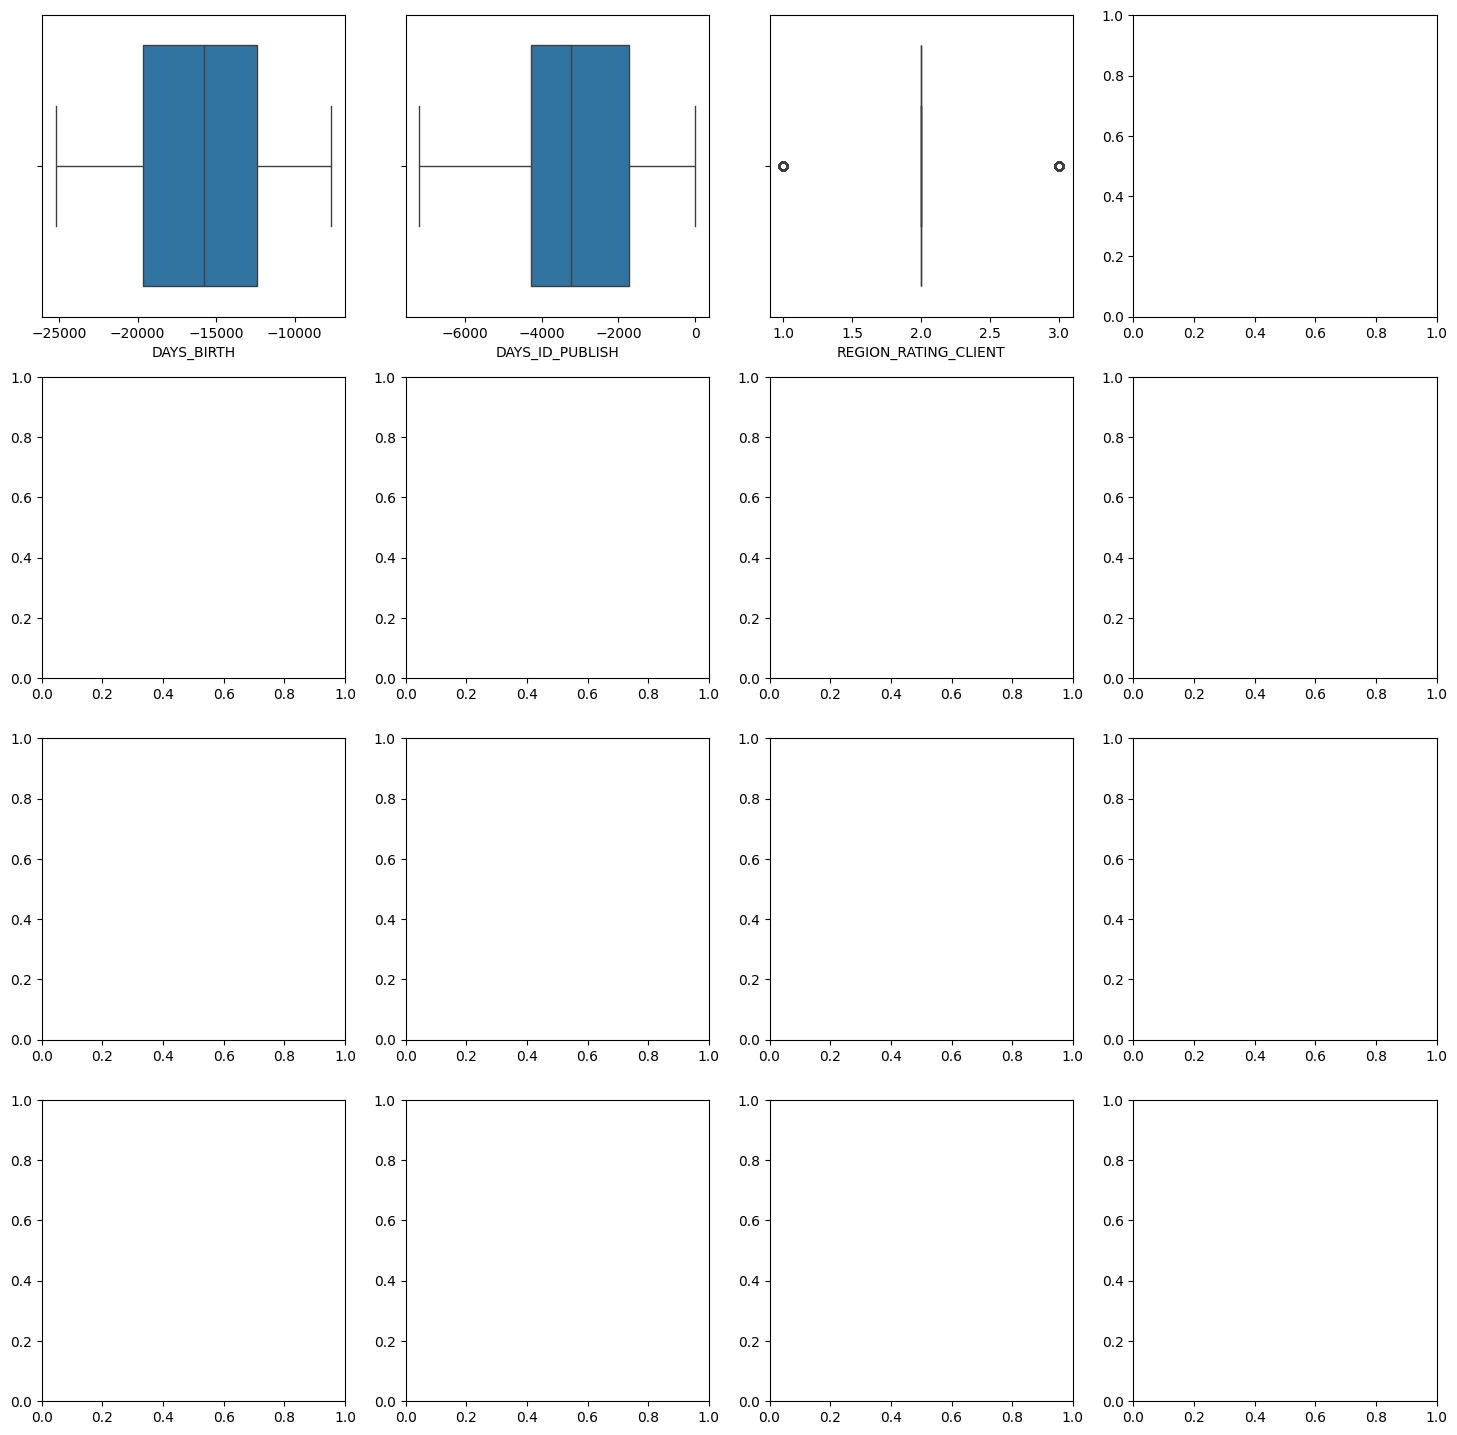

In [22]:
print("int or float columns : {}".format(len(numcolumns)))

fig , ax = plt.subplots(4 , 4 , figsize = (18 , 18))

for i in range(16):
    row = i // 4
    col = i % 4

    sns.boxplot(data = Ndf, x = Ndf[numcolumns[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(numcolumns[i])))
plt.show()

int or float columns : 16


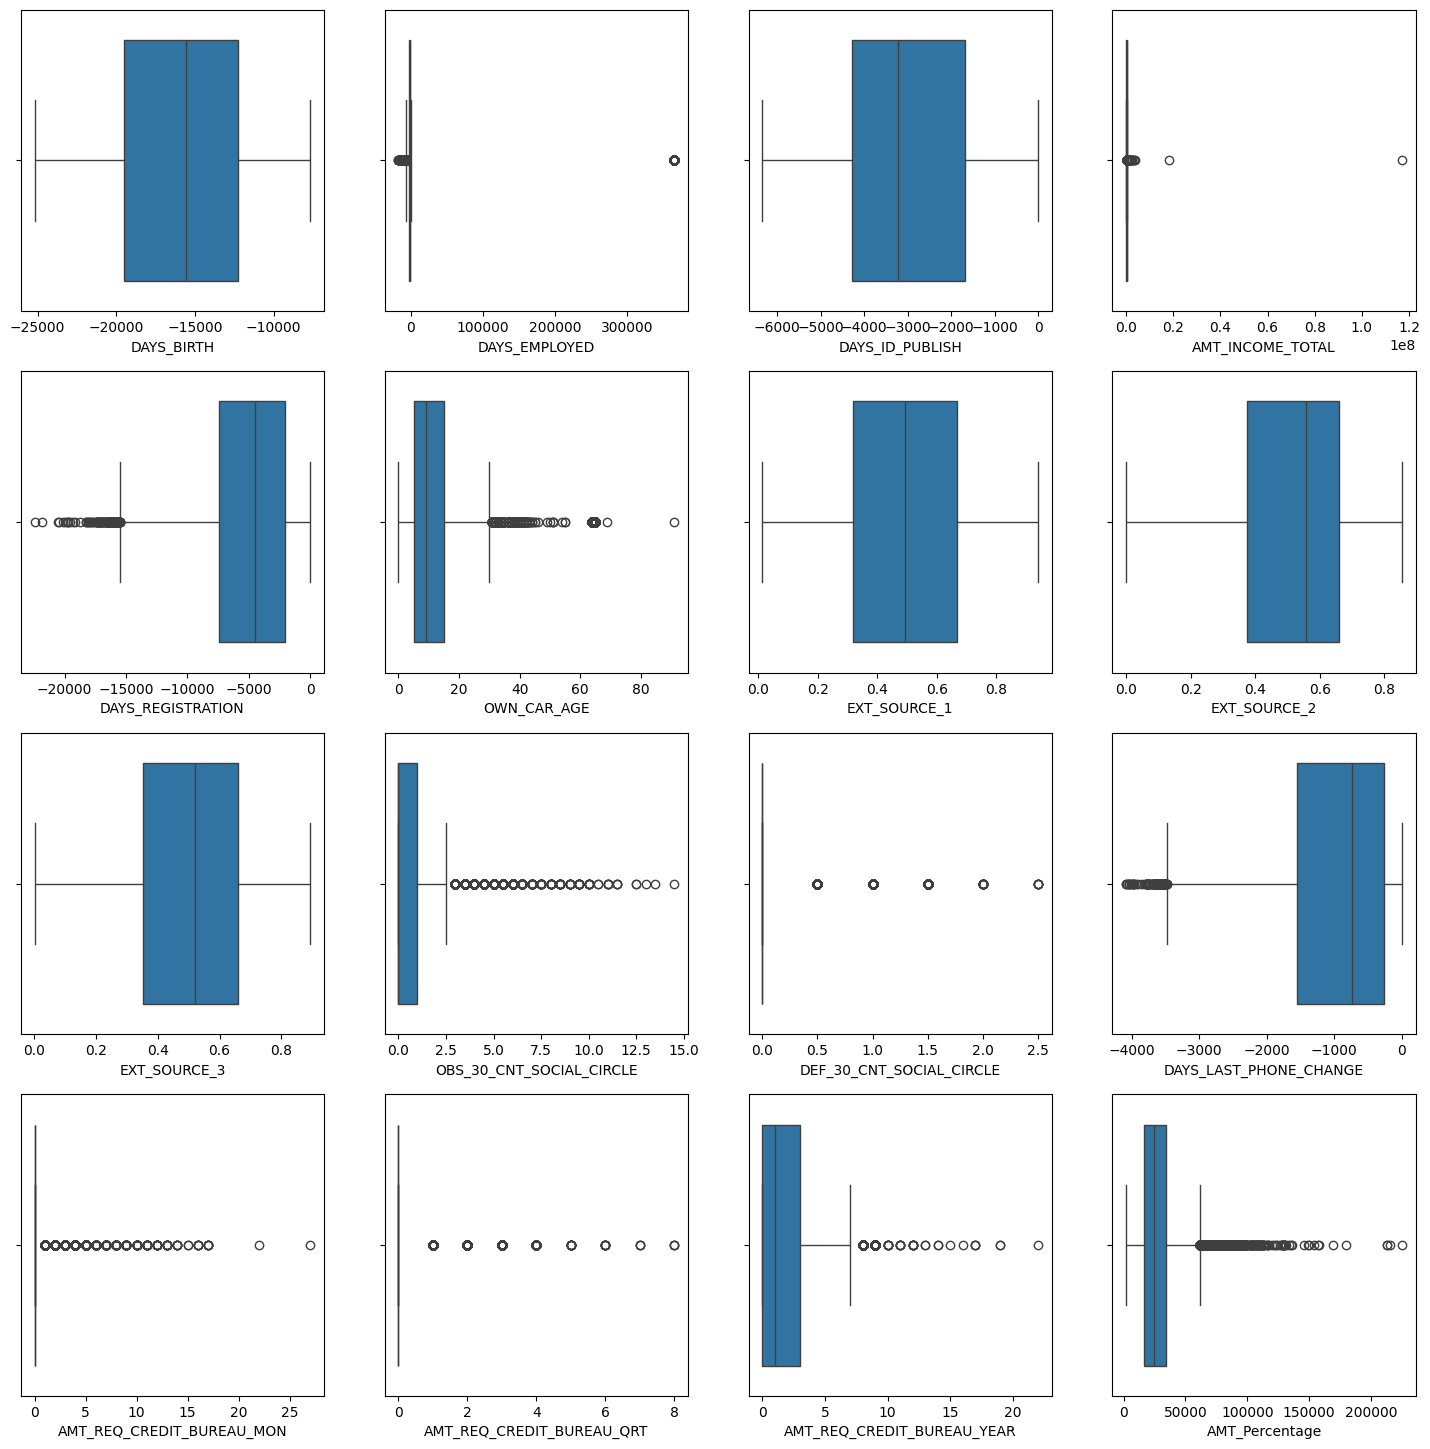

In [31]:
print("int or float columns : {}".format(len(numcolumns)))

fig , ax = plt.subplots(4 , 4 , figsize = (18 , 18))

for i in range(16):
    row = i // 4
    col = i % 4

    sns.boxplot(data = test, x = Ntest[numcolumns[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(numcolumns[i])))
plt.show()

In [24]:
# tukey

def tukey(data , c):
    q1 = np.percentile(data[c] , 25)
    q3 = np.percentile(data[c] , 75)

    IQR = q3 - q1

    upper_fence = q3 + 1.5 * IQR
    lower_fence = q1 - 1.5 * IQR

    return data[(data[c] < lower_fence) | (data[c] > upper_fence)]

In [23]:
outlierarray =['DAYS_EMPLOYED',
 'AMT_INCOME_TOTAL',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_Percentage']
 

In [28]:
# 비율 확인

length = df.shape[0]
t_length = test.shape[0]
for i in outlierarray:
    print("{0} Outlier Percentage :{1}%".format(i,round((tukey(Ndf , i).shape[0]) / length * 100 , 10)))
    print("Test {0} Outlier Percentage :{1}%".format(i,round((tukey(Ntest ,i).shape[0]) / t_length * 100,10)))


DAYS_EMPLOYED Outlier Percentage :0.0%
Test DAYS_EMPLOYED Outlier Percentage :0.0%
AMT_INCOME_TOTAL Outlier Percentage :4.5466758566%
Test AMT_INCOME_TOTAL Outlier Percentage :4.3756097561%
DAYS_REGISTRATION Outlier Percentage :0.2032686534%
Test DAYS_REGISTRATION Outlier Percentage :0.2325203252%
OWN_CAR_AGE Outlier Percentage :0.0%
Test OWN_CAR_AGE Outlier Percentage :0.0%
OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DAYS_LAST_PHONE_CHANGE Outlier Percentage :0.0%
Test DAYS_LAST_PHONE_CHANGE Outlier Percentage :0.1756097561%
AMT_REQ_CREDIT_BUREAU_MON Outlier Percentage :0.0%
Test AMT_REQ_CREDIT_BUREAU_MON Outlier Pe

In [20]:
# outlier
Ntest.loc[Ntest["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
Ntest['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
Ndf.loc[Ndf["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
Ndf['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)



In [30]:
print(Ndf["NAME_EDUCATION_TYPE"].unique())
print(Ntest["NAME_EDUCATION_TYPE"].unique())

['Higher education' 'Secondary / secondary special' 'Lower secondary'
 'Incomplete higher' 'Academic degree']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


In [31]:
print(Ndf["NAME_INCOME_TYPE"].unique())
print(Ntest["NAME_INCOME_TYPE"].unique())

['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Student'
 'Businessman' 'Maternity leave' 'Unemployed']
['Working' 'Commercial associate' 'State servant' 'Pensioner' 'Unemployed'
 'Student' 'Maternity leave' 'Businessman']


In [32]:

print(Ndf["NAME_HOUSING_TYPE"].unique())
print(Ntest["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']


In [87]:

print(Ndf["NAME_HOUSING_TYPE"].unique())
print(Ntest["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']


In [22]:
# CODE_GENDER
mode = Ndf["CODE_GENDER"].mode().iloc[0]
Ndf["CODE_GENDER"] = Ndf["CODE_GENDER"].replace('XNA', mode)

In [33]:
len(df_.columns)

52

In [34]:
Ndf[Ndf["NAME_FAMILY_STATUS"] == "Unknown"]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,DAYS_BIRTH_365_OWN_CAR_AGE,EXT_23_mean,EXT_12_mean,EXT_13_mean,EXT_123_mean,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
47453,47453,0,Revolving loans,F,N,202500.0,585000.0,29250.0,NaN,Commercial associate,...,NaN,0.65791,NaN,NaN,NaN,-6.628571,0.346154,NaN,0.144444,0.05
74592,74592,0,Revolving loans,M,N,450000.0,675000.0,33750.0,NaN,Commercial associate,...,NaN,NaN,NaN,NaN,NaN,-34.147059,0.666667,NaN,0.075000,0.05


In [23]:
# NAME_FAMILY_STATUS
print(Ndf["NAME_FAMILY_STATUS"].unique())
print(Ntest["NAME_FAMILY_STATUS"].unique())
mode = Ndf["NAME_FAMILY_STATUS"].mode().iloc[0]
Ndf["NAME_FAMILY_STATUS"] = Ndf["NAME_FAMILY_STATUS"].replace('Unknown', mode)

['Married' 'Widow' 'Single / not married' 'Separated' 'Civil marriage'
 'Unknown']
['Married' 'Single / not married' 'Separated' 'Civil marriage' 'Widow']


In [24]:
# ORGANIZATION_TYPE
mode = Ndf["ORGANIZATION_TYPE"].mode().iloc[0]
Ndf["ORGANIZATION_TYPE"] = Ndf["ORGANIZATION_TYPE"].replace('XNA', mode)

Tmode = Ntest["ORGANIZATION_TYPE"].mode().iloc[0]
Ntest["ORGANIZATION_TYPE"] = Ntest["ORGANIZATION_TYPE"].replace('XNA', Tmode)

#2
E = LabelEncoder()
Larray = ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR"]
for i in range(3):
    Labeled = E.fit_transform(Ndf[Larray[i]])
    Ndf[Larray[i]] = Labeled
    testLabeled = E.fit_transform(Ntest[Larray[i]])
    Ntest[Larray[i]] = testLabeled
    

In [25]:
#2
E = LabelEncoder()
Larray = ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR"]
for i in range(3):
    Labeled = E.fit_transform(Ndf[Larray[i]])
    Ndf[Larray[i]] = Labeled
    testLabeled = E.fit_transform(Ntest[Larray[i]])
    Ntest[Larray[i]] = testLabeled
    

In [26]:
# some
ColumnsOneHot = ["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"]
encoder = OneHotEncoder(sparse_output = False)

Ndf_encoded = pd.get_dummies(Ndf[ColumnsOneHot])

Ndf.drop(columns=ColumnsOneHot, inplace=True)
Ndf = pd.concat([Ndf, Ndf_encoded], axis=1)

Ntest_encoded = pd.get_dummies(Ntest[ColumnsOneHot])

Ntest.drop(columns=ColumnsOneHot, inplace=True)
Ntest = pd.concat([Ntest, Ntest_encoded], axis=1)

# some
ColumnsOneHot = ["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"]
encoder = OneHotEncoder(sparse_output = False)

Ndf_encoded = pd.get_dummies(Ndf[ColumnsOneHot])

Ndf.drop(columns=ColumnsOneHot, inplace=True)
Ndf = pd.concat([Ndf, Ndf_encoded], axis=1)

Ntest_encoded = pd.get_dummies(Ntest[ColumnsOneHot])

Ntest.drop(columns=ColumnsOneHot, inplace=True)
Ntest = pd.concat([Ntest, Ntest_encoded], axis=1)

In [94]:
Ndf["ORGANIZATION_TYPE"]

0                         School
1         Business Entity Type 3
2                         Postal
3         Business Entity Type 3
4         Business Entity Type 3
                   ...          
171197               Agriculture
171198          Industry: type 3
171199                    School
171200    Business Entity Type 3
171201              Kindergarten
Name: ORGANIZATION_TYPE, Length: 171202, dtype: object

In [27]:
# too many

encoder = TargetEncoder()
Ndf["ORGANIZATION_TYPE"] = encoder.fit_transform(Ndf["ORGANIZATION_TYPE"] ,Ndf["EXT_SOURCE_3"] )
Ntest["ORGANIZATION_TYPE"] = encoder.transform(Ntest["ORGANIZATION_TYPE"])


Ndf["OCCUPATION_TYPE"] = encoder.fit_transform(Ndf["OCCUPATION_TYPE"] ,Ndf["EXT_SOURCE_3"] )
Ntest["OCCUPATION_TYPE"] = encoder.transform(Ntest["OCCUPATION_TYPE"])


Ndf['MOBILE_OCCUPATION'] = encoder.fit_transform(Ndf['MOBILE_OCCUPATION'] ,Ndf["EXT_SOURCE_3"] )
Ntest['MOBILE_OCCUPATION'] = encoder.transform(Ntest['MOBILE_OCCUPATION'])
Ndf['HOUSING_INCOME'] = encoder.fit_transform(Ndf['HOUSING_INCOME'] ,Ndf["EXT_SOURCE_3"] )
Ntest['HOUSING_INCOME'] = encoder.transform(Ntest['HOUSING_INCOME'])

In [28]:
Ndf.drop([
"DEF_30_CNT_SOCIAL_CIRCLE",
"AMT_REQ_CREDIT_BUREAU_MON",
"EDU_INCOME_ABOVE_AVG",
"NAME_EDUCATION_TYPE_Academic degree",
"NAME_EDUCATION_TYPE_Lower secondary",
"NAME_FAMILY_STATUS_Civil marriage",
"NAME_FAMILY_STATUS_Single / not married",
"NAME_HOUSING_TYPE_House / apartment",
"NAME_HOUSING_TYPE_Municipal apartment",
"NAME_HOUSING_TYPE_Office apartment",
"NAME_HOUSING_TYPE_Rented apartment",
"REGION_RATING_CLIENT",
"OBS_60_CNT_SOCIAL_CIRCLE",
"NAME_FAMILY_STATUS_Widow",
"NAME_FAMILY_STATUS_Separated",
"NAME_HOUSING_TYPE_With parents",
"NAME_HOUSING_TYPE_Co-op apartment",
"NAME_EDUCATION_TYPE_Incomplete higher",
"NAME_INCOME_TYPE_Businessman",
"NAME_INCOME_TYPE_Commercial associate",
"NAME_INCOME_TYPE_Maternity leave",
"NAME_INCOME_TYPE_Pensioner",
"NAME_INCOME_TYPE_Student",
"NAME_INCOME_TYPE_Unemployed"
],axis = 1,inplace = True)
Ntest.drop([
"DEF_30_CNT_SOCIAL_CIRCLE",
"AMT_REQ_CREDIT_BUREAU_MON",
"EDU_INCOME_ABOVE_AVG",
"NAME_EDUCATION_TYPE_Academic degree",
"NAME_EDUCATION_TYPE_Lower secondary",
"NAME_FAMILY_STATUS_Civil marriage",
"NAME_FAMILY_STATUS_Single / not married",
"NAME_HOUSING_TYPE_House / apartment",
"NAME_HOUSING_TYPE_Municipal apartment",
"NAME_HOUSING_TYPE_Office apartment",
"NAME_HOUSING_TYPE_Rented apartment",
"REGION_RATING_CLIENT",
"OBS_60_CNT_SOCIAL_CIRCLE",
"NAME_FAMILY_STATUS_Widow",
"NAME_FAMILY_STATUS_Separated",
"NAME_HOUSING_TYPE_With parents",
"NAME_HOUSING_TYPE_Co-op apartment",
"NAME_EDUCATION_TYPE_Incomplete higher",
"NAME_INCOME_TYPE_Businessman",
"NAME_INCOME_TYPE_Commercial associate",
"NAME_INCOME_TYPE_Maternity leave",
"NAME_INCOME_TYPE_Pensioner",
"NAME_INCOME_TYPE_Student",
"NAME_INCOME_TYPE_Unemployed"
],axis = 1,inplace = True)

In [27]:
columns = list(Ndf.columns)
columns.remove('TARGET')
columns.remove('SK_ID_CURR')

In [21]:
Ntest.columns
columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary

In [16]:
Ndf.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_Percentage,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,0,0,0,0,N,112500.0,0.010032,-9233,-878.0,-333.0,-522,NaN,1,Core staff,2.0,2,0,0.059707,NaN,0.372591,NaN,0.0,0.0,-292.0,NaN,NaN,NaN,36329.393815,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
1,1,0,0,0,N,225000.0,0.008019,-20148,NaN,-4469.0,-3436,NaN,0,NaN,2.0,2,0,0.054243,NaN,0.449567,0.553165,0.0,0.0,-617.0,0.0,0.0,1.0,16894.000000,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False
2,2,0,0,0,N,54000.0,0.004960,-18496,-523.0,-3640.0,-2050,NaN,1,Core staff,2.0,2,0,0.082700,NaN,0.569503,NaN,2.0,0.0,-542.0,NaN,NaN,NaN,18257.308016,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False
3,3,0,0,0,N,67500.0,0.005002,-24177,NaN,-4950.0,-3951,NaN,0,NaN,1.0,3,0,0.054243,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,8901.883392,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False
4,4,1,0,1,N,157500.0,0.006296,-10685,-697.0,-5101.0,-3226,NaN,1,Drivers,2.0,3,0,0.093614,0.342344,0.202490,0.669057,0.0,0.0,-1243.0,0.0,0.0,4.0,21546.863257,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True


In [58]:
from sklearn.preprocessing import StandardScaler
X = Ndf[columns]
Y = Ndf["TARGET"]
scaler = StandardScaler()
X = scaler.fit_transform(X)
Test_X = Ntest[columns]
Test_X = scaler.transform(Test_X)

# Oversampling
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X, Y)
df_res_smote = pd.DataFrame(X_res_smote, columns= columns)
df_res_smote['price_range'] = y_res_smote

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [60]:
# LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.1, max_depth = 3, num_leaves = 10)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, lgb_valid_pred)}")

[LightGBM] [Info] Number of positive: 11021, number of negative: 125940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 136961, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436003
[LightGBM] [Info] Start training from score -2.436003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [61]:

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, xgb_valid_pred)}")

Train Score: 0.8217697674399503
Valid Score: 0.6456613804995297


In [46]:
# パラメータ探索範囲の定義
param_dist = {
    'num_leaves': randint(6, 50),  # 6から50の間の整数
    'learning_rate': uniform(0.01, 0.3),  # 0.01から0.3の間の一様分布
    'max_depth': randint(3, 15),  # 3から15の間の整数
    'min_child_samples': randint(20, 50),  # 20から50の間の整数
    'feature_fraction': uniform(0.5, 0.5),  # 0.5から1.0の間の一様分布
    'bagging_fraction': uniform(0.5, 0.5)  # 0.5から1.0の間の一様分布
}

# LightGBM分類器の定義
lgbm = LGBMClassifier(objective='binary', metric='auc', random_state=42)

# ランダムサーチの設定
n_iter_search = 20  # 試行回数を指定

random_search = RandomizedSearchCV(
    lgbm, param_distributions=param_dist, n_iter=n_iter_search, scoring='roc_auc', cv=5, random_state=42
)

# ランダムサーチの実行
random_search.fit(X_train, y_train)

print("Best Parameters found: ", random_search.best_params_)
print("Best ROC AUC Score found: {:.4f}".format(random_search.best_score_))

[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Info] Number of positive: 8859, number of negative: 8831
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6720
[LightGBM] [Info] Number of data points in the train set: 17690, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore

In [72]:
train_pred = (lgb_train_pred + xgb_train_pred)/2
valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, valid_pred)}")

Train Score: 0.8700175313166627
Valid Score: 0.7578783503796226


In [72]:


# データの準備（Xは特徴量、yは目的変数とする）
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのモデルを定義
model = LGBMClassifier()

# 探索するハイパーパラメータの範囲を指定
param_grid = {
    'num_leaves': [6,10,12,14],  # 6から50の間の整数
    'learning_rate': [0.1,0.2, 0.3],  # 0.01から0.3の間の一様分布
    'max_depth': [3,5,7,9],  # 3から15の間の整数

}

# GridSearchCVを用いて最適なハイパーパラメータを探索
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータとそのスコアを表示
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# テストデータでの性能評価（任意）
# test_accuracy = best_model.(X_test, y_test)
# print("Test set accuracy of best model: {:.2f}".format(test_accuracy))


[LightGBM] [Info] Number of positive: 7347, number of negative: 83960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6866
[LightGBM] [Info] Number of data points in the train set: 91307, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080465 -> initscore=-2.436048
[LightGBM] [Info] Start training from score -2.436048
[LightGBM] [Info] Number of positive: 7347, number of negative: 83960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6864
[LightGBM] [Info] Number of data points in the train set: 91307, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080465 -> initscore=-2.436048
[Lig

In [39]:
# LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.09, max_depth = 7, num_leaves = 12,n_estimators = 130)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, lgb_valid_pred)}")

[LightGBM] [Info] Number of positive: 11021, number of negative: 125940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8522
[LightGBM] [Info] Number of data points in the train set: 136961, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436003
[LightGBM] [Info] Start training from score -2.436003
Train Score: 0.7865941797025808
Valid Score: 0.7609104694961539


Feature: NAME_CONTRACT_TYPE, Importance: 14
Feature: CODE_GENDER, Importance: 27
Feature: FLAG_OWN_CAR, Importance: 2
Feature: AMT_INCOME_TOTAL, Importance: 18
Feature: AMT_CREDIT, Importance: 17
Feature: AMT_ANNUITY, Importance: 23
Feature: AMT_GOODS_PRICE, Importance: 38
Feature: REGION_POPULATION_RELATIVE, Importance: 20
Feature: DAYS_BIRTH, Importance: 32
Feature: DAYS_EMPLOYED, Importance: 34
Feature: DAYS_REGISTRATION, Importance: 26
Feature: DAYS_ID_PUBLISH, Importance: 49
Feature: OWN_CAR_AGE, Importance: 14
Feature: FLAG_WORK_PHONE, Importance: 17
Feature: OCCUPATION_TYPE, Importance: 9
Feature: CNT_FAM_MEMBERS, Importance: 3
Feature: REGION_RATING_CLIENT, Importance: 0
Feature: REGION_RATING_CLIENT_W_CITY, Importance: 19
Feature: REG_CITY_NOT_LIVE_CITY, Importance: 12
Feature: ORGANIZATION_TYPE, Importance: 15
Feature: EXT_SOURCE_1, Importance: 71
Feature: EXT_SOURCE_2, Importance: 82
Feature: EXT_SOURCE_3, Importance: 79
Feature: OBS_30_CNT_SOCIAL_CIRCLE, Importance: 9
Featu

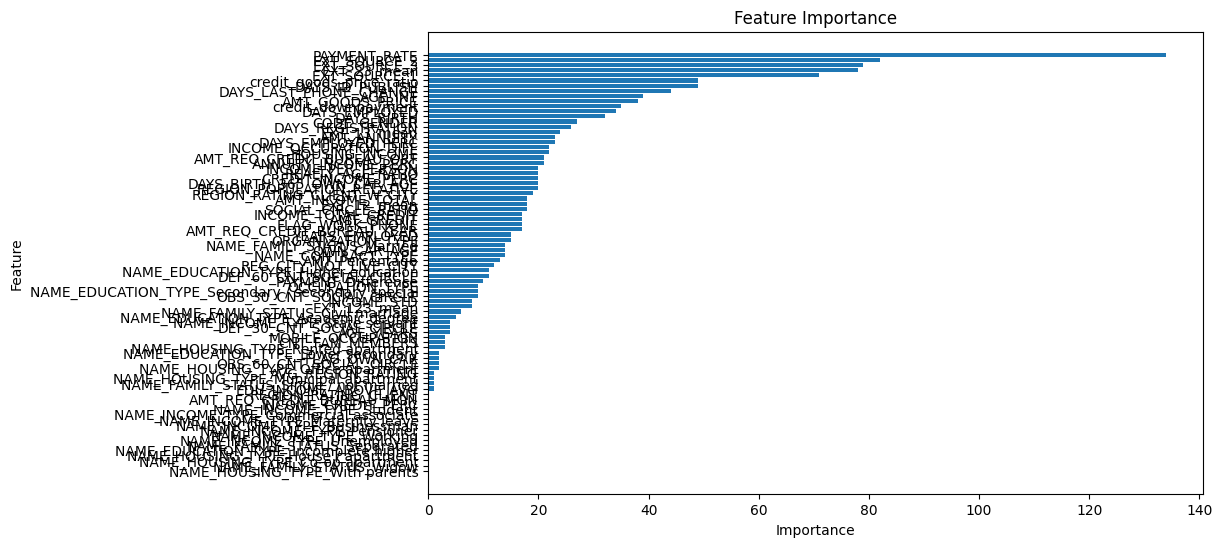

In [40]:
importance = lgb.feature_importances_
feature_names = columns
for feature, imp in zip(feature_names, importance):
    print(f"Feature: {feature}, Importance: {imp}")

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [41]:

for feature, imp in zip(feature_names, importance):
    if imp==0:

        print(f"Feature: {feature}, Importance: {imp}")

Feature: REGION_RATING_CLIENT, Importance: 0
Feature: AMT_REQ_CREDIT_BUREAU_MON, Importance: 0
Feature: INCOME_CREDIT_PERC, Importance: 0
Feature: NAME_INCOME_TYPE_Businessman, Importance: 0
Feature: NAME_INCOME_TYPE_Commercial associate, Importance: 0
Feature: NAME_INCOME_TYPE_Maternity leave, Importance: 0
Feature: NAME_INCOME_TYPE_Pensioner, Importance: 0
Feature: NAME_INCOME_TYPE_Student, Importance: 0
Feature: NAME_INCOME_TYPE_Unemployed, Importance: 0
Feature: NAME_INCOME_TYPE_Working, Importance: 0
Feature: NAME_EDUCATION_TYPE_Incomplete higher, Importance: 0
Feature: NAME_FAMILY_STATUS_Separated, Importance: 0
Feature: NAME_FAMILY_STATUS_Widow, Importance: 0
Feature: NAME_HOUSING_TYPE_Co-op apartment, Importance: 0
Feature: NAME_HOUSING_TYPE_House / apartment, Importance: 0
Feature: NAME_HOUSING_TYPE_With parents, Importance: 0


In [34]:
""" NAME_HOUSING_TYPE_Municipal 
NAME_HOUSING_TYPE_Co-op 
NAME_EDUCATION_TYPE_Lower
NAME_EDUCATION_TYPE_Incomplete

NAME_INCOME_TYPE_Businessman
NAME_INCOME_TYPE_Commercial 
NAME_INCOME_TYPE_Maternity 
NAME_INCOME_TYPE_Pensioner
NAME_INCOME_TYPE_Student
NAME_INCOME_TYPE_Unemployed

age_group """

' NAME_HOUSING_TYPE_Municipal \nNAME_HOUSING_TYPE_Co-op \nNAME_EDUCATION_TYPE_Lower\nNAME_EDUCATION_TYPE_Incomplete\n\nNAME_INCOME_TYPE_Businessman\nNAME_INCOME_TYPE_Commercial \nNAME_INCOME_TYPE_Maternity \nNAME_INCOME_TYPE_Pensioner\nNAME_INCOME_TYPE_Student\nNAME_INCOME_TYPE_Unemployed\n\nage_group '

In [50]:
print(df_["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']


# "NAME_INCOME_TYPE"
'Working' 'State servant'  


['Pensioner','Commercial associate','Student','Businessman','Maternity leave','Unemployed']

# "NAME_EDUCATION_TYPE"
'Higher education' 'Secondary / secondary special' 'Academic degree'

['Lower secondary','Incomplete higher'] 

'House / apartment','With parents','Rented apartment','Office apartment' 

 ['Co-op apartment','Municipal apartment'] 

In [34]:
from sklearn.metrics import accuracy_score

In [29]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    Taccuracy = accuracy_score(y_train, y_pred_train)
    accuracy = accuracy_score(y_test, y_pred)
    print(Taccuracy)
    print(accuracy)
    return accuracy

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)


[I 2024-06-29 17:03:41,505] A new study created in memory with name: no-name-95f42abb-e008-4a66-8fbc-3f3907e587e4
[I 2024-06-29 17:03:42,437] Trial 0 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.0016769643896413788, 'lambda_l2': 9.399730539571532e-05, 'num_leaves': 6, 'learning_rate': 0.011100803283051505, 'feature_fraction': 0.677296116757574, 'bagging_fraction': 0.609065075395647, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:43,578] Trial 1 finished with value: 0.9125609649250898 and parameters: {'lambda_l1': 1.6099825796331248e-08, 'lambda_l2': 1.5044977001484506e-05, 'num_leaves': 31, 'learning_rate': 0.5715820681339845, 'feature_fraction': 0.4368829012880192, 'bagging_fraction': 0.8117335631563346, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 0 with value: 0.9182266873046933.


0.9266506523754937
0.9125609649250898


[I 2024-06-29 17:03:45,122] Trial 2 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 4.3632406455885284e-05, 'lambda_l2': 0.10296929453019621, 'num_leaves': 180, 'learning_rate': 0.00022667078095270484, 'feature_fraction': 0.8974344737269677, 'bagging_fraction': 0.6114146470194852, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:46,945] Trial 3 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.0031807124175088986, 'lambda_l2': 0.000528061208244448, 'num_leaves': 224, 'learning_rate': 0.0013444491763595894, 'feature_fraction': 0.9015166190561751, 'bagging_fraction': 0.7448457833523057, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:48,472] Trial 4 finished with value: 0.9182850968137612 and parameters: {'lambda_l1': 0.00010496375324420229, 'lambda_l2': 0.0030563986127580063, 'num_leaves': 153, 'learning_rate': 0.025242445810846118, 'feature_fraction': 0.42208010950419295, 'bagging_fraction': 0.6796030104497979, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 4 with value: 0.9182850968137612.


0.9198019874270777
0.9182850968137612


[I 2024-06-29 17:03:49,891] Trial 5 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 3.9206386584935564, 'lambda_l2': 2.4390970693693555e-07, 'num_leaves': 103, 'learning_rate': 0.0005605255490329474, 'feature_fraction': 0.9122637843083582, 'bagging_fraction': 0.5174655767076807, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 4 with value: 0.9182850968137612.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:51,809] Trial 6 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.23906475474428104, 'lambda_l2': 0.0002000207369026338, 'num_leaves': 202, 'learning_rate': 0.0054551053031033185, 'feature_fraction': 0.7004427961549038, 'bagging_fraction': 0.9490988136687297, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 4 with value: 0.9182850968137612.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:53,407] Trial 7 finished with value: 0.9182850968137612 and parameters: {'lambda_l1': 1.605734585780504e-07, 'lambda_l2': 0.004725398122967824, 'num_leaves': 164, 'learning_rate': 0.01545555743891436, 'feature_fraction': 0.7150827856665346, 'bagging_fraction': 0.6419713830837444, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 4 with value: 0.9182850968137612.


0.9195683442731872
0.9182850968137612


[I 2024-06-29 17:03:55,438] Trial 8 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.12311109983187679, 'lambda_l2': 4.6126012050765764e-08, 'num_leaves': 249, 'learning_rate': 0.00020964451607669347, 'feature_fraction': 0.9346915840707118, 'bagging_fraction': 0.8493717061890451, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 4 with value: 0.9182850968137612.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:56,706] Trial 9 finished with value: 0.914313250197132 and parameters: {'lambda_l1': 1.2126756288973475e-06, 'lambda_l2': 8.748324973020317, 'num_leaves': 69, 'learning_rate': 0.29170778195882757, 'feature_fraction': 0.940227900232739, 'bagging_fraction': 0.42607289016132494, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 4 with value: 0.9182850968137612.


0.9277604573564737
0.914313250197132


[I 2024-06-29 17:03:58,187] Trial 10 finished with value: 0.9185771443591016 and parameters: {'lambda_l1': 4.4256342148518235e-05, 'lambda_l2': 0.12884324982666187, 'num_leaves': 134, 'learning_rate': 0.07299211889059545, 'feature_fraction': 0.4050178458297255, 'bagging_fraction': 0.9671093602884333, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 10 with value: 0.9185771443591016.


0.9229050605646864
0.9185771443591016


[I 2024-06-29 17:03:59,632] Trial 11 finished with value: 0.9182850968137612 and parameters: {'lambda_l1': 2.3749416482057852e-05, 'lambda_l2': 0.1426424805985185, 'num_leaves': 132, 'learning_rate': 0.0755262344023358, 'feature_fraction': 0.4004163892830596, 'bagging_fraction': 0.9338589618428399, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 10 with value: 0.9185771443591016.


0.9234891684494126
0.9182850968137612


[I 2024-06-29 17:04:01,231] Trial 12 finished with value: 0.9181974825501592 and parameters: {'lambda_l1': 9.91711606812875e-06, 'lambda_l2': 0.06022393333568643, 'num_leaves': 133, 'learning_rate': 0.05634318638632246, 'feature_fraction': 0.5177317147793052, 'bagging_fraction': 0.9999427191392138, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 10 with value: 0.9185771443591016.


0.92232095267996
0.9181974825501592


[I 2024-06-29 17:04:02,612] Trial 13 finished with value: 0.9186647586227038 and parameters: {'lambda_l1': 0.00035240278276659967, 'lambda_l2': 3.3602464271941526, 'num_leaves': 84, 'learning_rate': 0.05337961575790194, 'feature_fraction': 0.539258644115885, 'bagging_fraction': 0.7243925148353267, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 13 with value: 0.9186647586227038.


0.9206343411628127
0.9186647586227038


[I 2024-06-29 17:04:03,919] Trial 14 finished with value: 0.9185479396045676 and parameters: {'lambda_l1': 0.0031532468304995977, 'lambda_l2': 9.533731519307514, 'num_leaves': 71, 'learning_rate': 0.20958495230512716, 'feature_fraction': 0.5584627000476718, 'bagging_fraction': 0.8495035761865669, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 13 with value: 0.9186647586227038.


0.9243361248822658
0.9185479396045676


[I 2024-06-29 17:04:05,346] Trial 15 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 9.854492666601922e-07, 'lambda_l2': 0.48059777743247073, 'num_leaves': 93, 'learning_rate': 0.0030780398991018345, 'feature_fraction': 0.5592674172012356, 'bagging_fraction': 0.786550860030072, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 13 with value: 0.9186647586227038.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:04:06,427] Trial 16 finished with value: 0.9183727110773634 and parameters: {'lambda_l1': 0.0005353289803494577, 'lambda_l2': 0.6125430287387245, 'num_leaves': 56, 'learning_rate': 0.09391933615382224, 'feature_fraction': 0.49593401991153474, 'bagging_fraction': 0.5294874713844028, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 13 with value: 0.9186647586227038.


0.9217514474923518
0.9183727110773634


[I 2024-06-29 17:04:07,558] Trial 17 finished with value: 0.8763762740574166 and parameters: {'lambda_l1': 0.02508810647494194, 'lambda_l2': 0.008264650568402419, 'num_leaves': 105, 'learning_rate': 0.8958232691061596, 'feature_fraction': 0.6038129732789932, 'bagging_fraction': 0.8855750452630369, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 13 with value: 0.9186647586227038.


0.9095727980958083
0.8763762740574166


[I 2024-06-29 17:04:08,596] Trial 18 finished with value: 0.9182850968137612 and parameters: {'lambda_l1': 3.621892979098701e-06, 'lambda_l2': 1.706249171327399, 'num_leaves': 33, 'learning_rate': 0.030062977086675925, 'feature_fraction': 0.7958363239453482, 'bagging_fraction': 0.7350447651497992, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 13 with value: 0.9186647586227038.


0.9196194537131008
0.9182850968137612


[I 2024-06-29 17:04:09,822] Trial 19 finished with value: 0.9145760929879384 and parameters: {'lambda_l1': 0.00024386193627335518, 'lambda_l2': 3.8404256989103024e-06, 'num_leaves': 117, 'learning_rate': 0.19879913586973644, 'feature_fraction': 0.4748610586013574, 'bagging_fraction': 0.5427897558351147, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 13 with value: 0.9186647586227038.


0.9361716108965326
0.9145760929879384


In [29]:
tdf = Ndf.copy()
ttest = Ntest.copy()
tdf = tdf.dropna(axis=1)
ttest = ttest.dropna(axis = 1)

In [30]:
null_counts = tdf.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

Series([], dtype: int64)


In [31]:
null_counts = ttest.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

Series([], dtype: int64)


In [1]:

plt.figure(figsize=(18, 18))

sns.heatmap(data = tdf.select_dtypes(['int' , 'float']).corr('spearman'),
            annot = True ,
            fmt = '.2f' ,
            
            cmap = 'coolwarm')

NameError: name 'plt' is not defined

In [32]:
tdf.drop(["AGE_INT","INCOME_TOTAL_CREDIT","AVG_REGION_RATING",
          "CREDIT_INCOME_PERC","DAYS_BIRTH","AMT_INCOME_TOTAL","INCOME_STD","AMT_CREDIT",'INCOME_STD'],axis = 1,inplace = True)
ttest.drop(["AGE_INT","INCOME_TOTAL_CREDIT","AVG_REGION_RATING",
          "CREDIT_INCOME_PERC","DAYS_BIRTH","AMT_INCOME_TOTAL","AMT_CREDIT"],axis = 1,inplace = True)

In [33]:
columns = list(tdf.columns)
columns.remove('TARGET')
columns.remove('SK_ID_CURR')

In [34]:

from sklearn.preprocessing import MinMaxScaler
tX = tdf[columns]
tY = tdf["TARGET"]
scaler = MinMaxScaler()
tX = scaler.fit_transform(tX)
tTest_X = ttest[columns]
tTest_X = scaler.transform(tTest_X)

Resampled dataset shape Counter({0: 13821, 1: 13821})


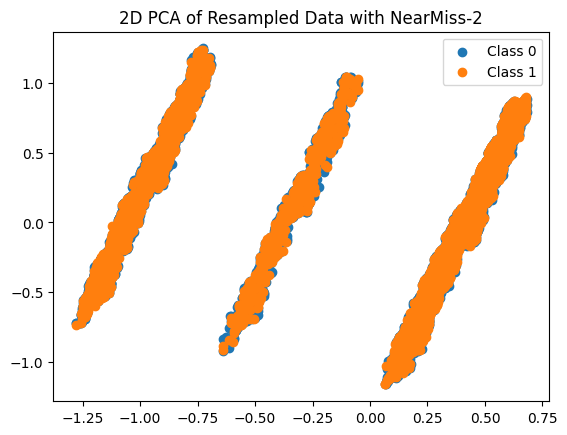

In [35]:

from imblearn.under_sampling import NearMiss
# NearMiss-2の適用
nm2 = NearMiss(version=3)  # NearMissのバージョンを2に設定
X_res, y_res = nm2.fit_resample(tX,tY)

# アンダーサンプリング後のデータのクラス分布の確認
print('Resampled dataset shape %s' % Counter(y_res))

# データの可視化（オプション）
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_res_pca = pca.fit_transform(X_res)
plt.scatter(X_res_pca[y_res == 0, 0], X_res_pca[y_res == 0, 1], label='Class 0')
plt.scatter(X_res_pca[y_res == 1, 0], X_res_pca[y_res == 1, 1], label='Class 1')
plt.legend()
plt.title('2D PCA of Resampled Data with NearMiss-2')
plt.show()

In [36]:
tX_train, tX_test, ty_train, ty_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [50]:
et  = ExtraTreesClassifier()
et.fit(tX_train, ty_train)

et_train_pred = et.predict_proba(tX_train)[:, 1]
et_valid_pred = et.predict_proba(tX_test)[:, 1]
print(f"Train Score: {roc_auc_score(ty_train, et_train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, et_valid_pred)}")


Train Score: 1.0
Valid Score: 0.6932378619954531


In [37]:
lr = LogisticRegression(random_state=0)
lr.fit(tX_train, ty_train)

lr_train_pred = lr.predict_proba(tX_train)[:, 1]
lr_valid_pred = lr.predict_proba(tX_test)[:, 1]
print(f"Train Score: {roc_auc_score(ty_train, lr_train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, lr_valid_pred)}")

Train Score: 0.7260216429696457
Valid Score: 0.724653284924643


In [38]:
lr.predict_proba(tTest_X)[:, 1]

array([0.52039686, 0.66072447, 0.53918396, ..., 0.33927076, 0.3335872 ,
       0.71395276])

In [74]:
print(f"Train ROC AUC Score: {train_roc_auc}")
print(f"Test ROC AUC Score: {test_roc_auc}")

Train ROC AUC Score: 0.6533243335485335
Test ROC AUC Score: 0.6619799862708865


In [39]:
GBC = GradientBoostingClassifier(max_depth = 4,subsample = 0.5374697790412601,min_samples_leaf= 20)
GBC.fit(tX_train, ty_train)
GBC_train_pred = GBC.predict_proba(tX_train)[:, 1]
GBC_valid_pred = GBC.predict_proba(tX_test)[:, 1]
print(f"Train Score: {roc_auc_score(ty_train, GBC_train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, GBC_valid_pred)}")

Train Score: 0.7936701280892184
Valid Score: 0.7553885985548053


In [74]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
}

gbc = GradientBoostingClassifier()

# GridSearchCVの例
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


# トレーニングデータでフィッティング
grid_search.fit(X_train, y_train)

# 最適なパラメータの表示
print("Best parameters found by GridSearchCV:", grid_search.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 

In [40]:
MLP = MLPClassifier()
MLP.fit(tX_train, ty_train)
MLP_train_pred = MLP.predict_proba(tX_train)[:, 1]
MLP_valid_pred = MLP.predict_proba(tX_test)[:, 1]
print(f"Train Score: {roc_auc_score(ty_train,MLP_train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, MLP_valid_pred)}")

Train Score: 0.7844097182951417
Valid Score: 0.7417963574144149


In [62]:
tY[tY == 0]

0        0
1        0
2        0
3        0
4        0
        ..
13816    0
13817    0
13818    0
13819    0
13820    0
Name: TARGET, Length: 13821, dtype: int64

In [63]:
tY[tY == 1]

13821    1
13822    1
13823    1
13824    1
13825    1
        ..
27637    1
27638    1
27639    1
27640    1
27641    1
Name: TARGET, Length: 13821, dtype: int64

In [64]:
tX

array([[0.01142208, 0.1011236 , 0.42857143, ..., 0.        , 1.        ,
        0.        ],
       [0.01142208, 0.06952809, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.02144145, 0.04494382, 0.14285714, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.01810166, 0.17721348, 0.42857143, ..., 0.        , 0.        ,
        0.        ],
       [0.00808229, 0.12471685, 0.42857143, ..., 1.        , 0.        ,
        1.        ],
       [0.0064124 , 0.04026966, 1.        , ..., 0.        , 1.        ,
        0.        ]])

DecisionTreeClassifier,
KNeighborsClassifier,AdaBoostClassifier,
RandomForestClassifier,VotingClassifier,

In [77]:
train_pred = (lgb_train_pred + xgb_train_pred + lr_train_pred)/3
valid_pred = (lgb_valid_pred + xgb_valid_pred + lr_valid_pred)/3

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, valid_pred)}")

ValueError: operands could not be broadcast together with shapes (136961,) (22113,) 

In [149]:
train_pred = (GBC_train_pred+ lr_train_pred)/2
valid_pred = (GBC_valid_pred + lr_valid_pred)/2

print(f"Train Score: {roc_auc_score(ty_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, valid_pred)}")

Train Score: 0.6876772881523179
Valid Score: 0.6695938310758928


In [31]:
print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Best hyperparameters:", trial.params)


Best trial:
Accuracy: 0.9186647586227038
Best hyperparameters: {'lambda_l1': 0.00035240278276659967, 'lambda_l2': 3.3602464271941526, 'num_leaves': 84, 'learning_rate': 0.05337961575790194, 'feature_fraction': 0.539258644115885, 'bagging_fraction': 0.7243925148353267, 'bagging_freq': 4, 'min_child_samples': 23}


In [134]:
pred = lgb.predict_proba(Test_X)[:, 1]
pred2 = xgb.predict_proba(Test_X)[:, 1]
pred = (pred+pred2)/2
sample_sub['TARGET'] = pred
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.025693
1,171203,0.173078
2,171204,0.112114
3,171205,0.108970
4,171206,0.177011
...,...,...
61495,232697,0.197381
61496,232698,0.059840
61497,232699,0.050417
61498,232700,0.240662


In [ ]:

plt.figure(figsize=(18, 18))

sns.heatmap(data = Ndf.select_dtypes(['int' , 'float']).corr('spearman'),
            annot = True ,
            fmt = '.2f' ,
            
            cmap = 'coolwarm')

In [135]:
sample_sub.to_csv("mix.csv", index=False)


# ORGANIZATION_TYPE

# site

https://toshikishimizu.hatenablog.com/entry/2018/09/16/113851#%E3%82%B3%E3%83%B3%E3%83%9A%E3%81%AE%E6%A6%82%E8%A6%81

https://data-analysis-stats.jp/kaggle/kaggle1%e4%bd%8d%e3%81%ae%e8%a7%a3%e6%9e%90%e6%89%8b%e6%b3%95%e3%80%80%e3%80%8chome-credit-default-risk-%e5%82%b5%e5%8b%99%e4%b8%8d%e5%b1%a5%e8%a1%8c%e3%81%ae%e4%ba%88%e6%b8%ac%e3%80%8d%e2%91%a1/

https://www.kaggle.com/code/ogrellier/good-fun-with-ligthgbm

In [ ]:
# heatmap
#smote
#parameter tuning